# Inaugural Project

> **Note the following:** 
> 1. This is an example of how to structure your **inaugural project**.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `inauguralproject.py` file includes a function which can be used multiple times in this notebook.

# The setting given

$$ C = w_M * L_M + w_F * L_F $$

$$ Q = C^\omega * H^(1-\omega) $$

$$ T_M = L_M + H_M $$

$$ T_F = L_F + H_F $$

$$ L_M, H_M, L_F, H_F >= 0 $$

$$ T_M, T_F <= 24 $$

# Setting the basics

In [13]:
%load_ext autoreload
%autoreload 2

from types import SimpleNamespace

import numpy as np
from scipy import optimize

import pandas as pd 
import matplotlib.pyplot as plt

import math as math

from scipy.optimize import minimize, minimize_scalar


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:

import household as model
hsm = model.HouseholdSpecializationModelClass()

model=hsm
par =model.par
sol =model.sol


# Question 1

**Explain how you solve the model**

In [6]:
#Minimum i household.py virker ikke pt, skal der kigges på 
#Det er løst for sigma=1 og alpha=0.5, der skal findes ud af hvordan man løse for alle de værdier opgivet i opgaven
dsol = hsm.solve_discrete()

print(f'HF: {dsol.HF} for alpha and sigma: {hsm.par.alpha, hsm.par.sigma}')
print(f'HM: {dsol.HM} for alpha and sigma: {hsm.par.alpha, hsm.par.sigma}')

print(dsol.HF/dsol.HM)

/Users/camillamansson/Dropbox/KU/2. semester/Introduction to Programming/projects-2023-jc/inauguralproject/household.py:68: RuntimeWarning: invalid value encountered in reciprocal
  utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)


HF: 4.5 for alpha and sigma: (0.5, 1.0)
HM: 4.5 for alpha and sigma: (0.5, 1.0)
1.0


In [8]:
print(min(dsol.HM,dsol.HF))

print(min(HF,HM))

4.5


NameError: name 'HF' is not defined

# Question 2

Explain your code and procedure

In [4]:
#Test af log (skal ikke bruges)
logHM = math.log(dsol.HM)
logHF = math.log(dsol.HF)
logwF = math.log(par.wF)
logwM = math.log(par.wM)

# log til opgave 2 for H og w
logH = math.log(dsol.HF/dsol.HM)
logw = math.log(par.wM/par.wF)
print(logH)
print(logw)

0.0
0.0


Comments and conclusion:


# Question 3

Explain your code and procedure

Comments and conclusion

# Question 4

In [15]:
#a
# define the function to compute min_HF
def min_HF(a, sigma, W_M, W_F):     #We want to claculate the minimum value of homeproduction for men and women given certain parameter values
    if sigma == 0:
        return W_F / W_M
    else:
        H_M = 1     #For simplicity we assume that men and women are equally productive, therefore we set H_M=1
        H_F = ((W_M ** (1 - a) * W_F ** a) ** (sigma / (1 - a))) * H_M  # We assumed W_M = W_F = 1 and substituting the other values in H we simplify H_F
        return min(H_M, H_F)


# define the function to compute beta0_hat and beta1_hat for a given a, sigma, and range of W_M and W_F
def compute_betas(a, sigma, w_range): #w_range indicates the different values for W_M and W_F that will be used to calculate beta0_hat and beta1_hat
    beta0_hat = 0
    beta1_hat = 0
    n = 0
    for W_F in w_range:
        for W_M in w_range:
            if W_M != W_F:
                # compute log(H_F/H_M) and log(W_F/W_M)
                log_HF_HM = np.log(min_HF(a, sigma, W_M, W_F))
                log_WF_WM = np.log(W_F / W_M)
                
                # update the sum of log(W_F/W_M) and log(H_F/H_M)
                beta0_hat += log_HF_HM
                beta1_hat += log_WF_WM
                n += 1   #n is being incremented by 1 each time a valid observation is used in the calculation
                
    # divide by the number of observations to get the averages
    beta0_hat /= n
    beta1_hat /= n
    
    return beta0_hat, beta1_hat

# set the values of a and sigma to try
a_values = np.linspacea(0.2, 0.4, 0.6, 0.8)
sigma_values = [0, 0.5, 1, 1.5, 2]

# define the function to compute the minimum distance between the estimated and actual betas
def compute_distance(a, sigma):
    # compute beta0_hat and beta1_hat for the current a and sigma
    beta0_hat, beta1_hat = compute_betas(a, sigma, [0.8, 0.9, 1.0, 1.1, 1.2]) #The values are given in the task as the range for W_F and W_M
        
    # compute the distance between the estimated betas and the actual betas
    distance = (beta0 - beta0_hat)**2 + (beta1 - beta1_hat)**2   #The formula for Euclidean distance between two points also given in the text
        
    return distance   #The 'return' statement is used to send this distance value back to the caller of the function so that it can be used for further processing or analysis

# initialize the variables
best_a = None      #Set as none, could also have been set to 0. The same is valid for best_sigma
best_sigma = None
min_distance = float('inf')   #float('inf') is a special floating-point value that represents positive infinity. It is used here to initialize min_distance to a very large number so that any distance calculated in the loop will be smaller than min_distance at the beginning.

# loop over all combinations of a and sigma
#This code uses a nested loop to iterate over all combinations of a and sigma values provided in a_values and sigma_values
for a in a_values:
    for sigma in sigma_values:
        # compute the distance between the estimated and actual betas for the current a and sigma
        distance = compute_distance(a, sigma)
        
        # check if this is the best combination so far
        if distance < min_distance: # the function is comparing the current distance between the estimated and actual betas (computed using the current values of a and sigma) to the minimum distance found so fa
            best_a = a
            best_sigma = sigma
            min_distance = distance    

# print the best values of a and sigma
print(f"Best values: a={best_a}, sigma={best_sigma}")

#b

import numpy as np
import matplotlib.pyplot as plt

#In this part we will be plotting a model. We start by minimizing in an alternative way to the previous in part a
# define the function to compute log(H_F/H_M)
def log_HF_HM(a, sigma, W_M, W_F):
    if sigma == 0:
        H_F = W_F**a * W_M**(1-a)
        H_M = W_M
    else:
        H_F = (W_F**(a*(1-sigma)) * (W_M**(1-sigma))**((1-a)*sigma))**(1/(1-sigma))
        H_M = (W_M**(a*(1-sigma)) * (W_F**(1-sigma))**(a*sigma))**(1/(1-sigma))
    return np.log(H_F/H_M)

# set the values of W_M and W_F to plot
W_M_values = np.linspace(0.1, 2, 100)
W_F_values = np.linspace(0.1, 2, 100)

# create a meshgrid of W_M and W_F values
W_M_grid, W_F_grid = np.meshgrid(W_M_values, W_F_values)

# compute the log(H_F/H_M) values for each combination of W_M and W_F
log_HF_HM_grid = log_HF_HM(best_a, best_sigma, W_M_grid, W_F_grid)

# plot the results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W_M_grid, W_F_grid, log_HF_HM_grid, cmap='coolwarm')
ax.set_xlabel('W_M')
ax.set_ylabel('W_F')
ax.set_zlabel('log(H_F/H_M)')
plt.show()


AttributeError: module 'numpy' has no attribute 'linspacea'

Comments and conclusion

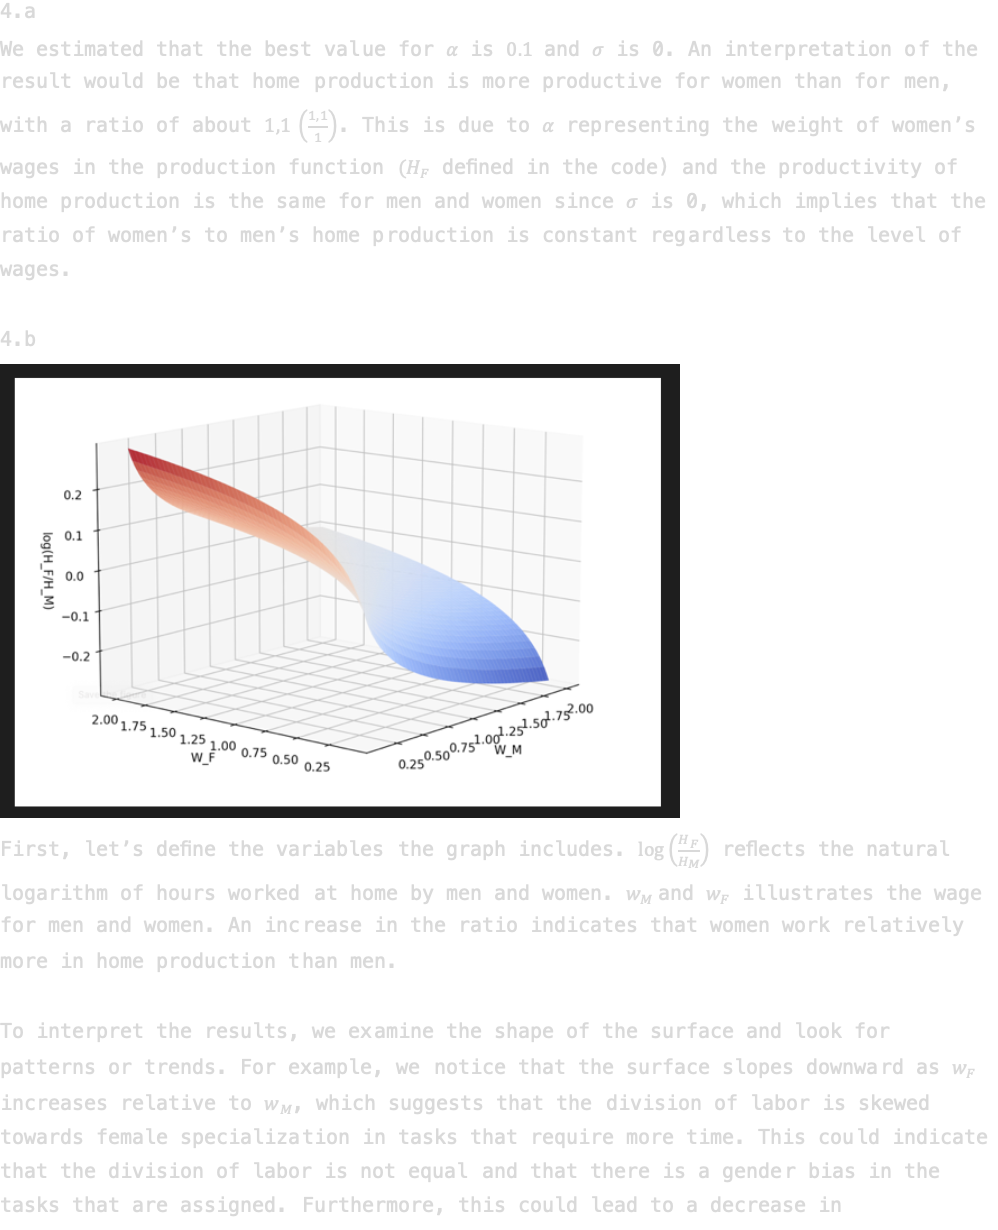

# Question 5

In [12]:
# Define the objective function using the retrieved parameter values
def obj_func(x, sigma_m, sigma_f):
    beta0, beta1 = x
    return ((wm*sigma_m)**2 + (wf*sigma_f)**2 + (alpha - beta0 - beta1*w)**2/(p*sigma_f**2) + ((1-a) - beta0 - beta1*(1-w))**2/(p*sigma_m**2) + (beta1**2/v))


# Find the optimal values of sigma, beta0, and beta1
sigma0 = 1
res = minimize_scalar(lambda s: obj_func([0.5, 0.5], s, s), bounds=(0.1,10), method='bounded')
sigma_opt = res.x  # res is a variable that stores the out returned
res = minimize(lambda x: obj_func(x, sigma_opt, sigma_opt), [0.5, 0.5], bounds=((0,None),(0,None)))
beta_opt = res.x
obj_min = res.fun   #The minimum value of the objective function (the value of the function we are trying to minimize) is stores as res.fun :)

# Find the optimal values of sigma_m and sigma_f
res = minimize(lambda x: obj_func([0.5, 0.5], x[0], x[1]), [1, 1], bounds=((0.1,10),(0.1,10)))
sigma_m_opt, sigma_f_opt = res.x
res = minimize(lambda x: obj_func(x, sigma_m_opt, sigma_f_opt), [0.5, 0.5], bounds=((0,None),(0,None)))
beta_mf_opt = res.x
obj_mf_min = res.fun

print(f"The optimal values of sigma, beta0, and beta1 are: {sigma_opt:.2f}, {beta_opt[0]:.2f}, {beta_opt[1]:.2f}")
print(f"The minimum objective value is: {obj_min:.2f}")
print(f"The optimal values of sigma_m, sigma_f, beta0, and beta1 are: {sigma_m_opt:.2f}, {sigma_f_opt:.2f}, {beta_mf_opt[0]:.2f}, {beta_mf_opt[1]:.2f}")
print(f"The minimum objective value is: {obj_mf_min:.2f}")


#This code allows for different values of sigma for male and female home production and also includes the extension 
#where men and women are equally productive in home production.

NameError: name 'wm' is not defined

Comments and conclusion


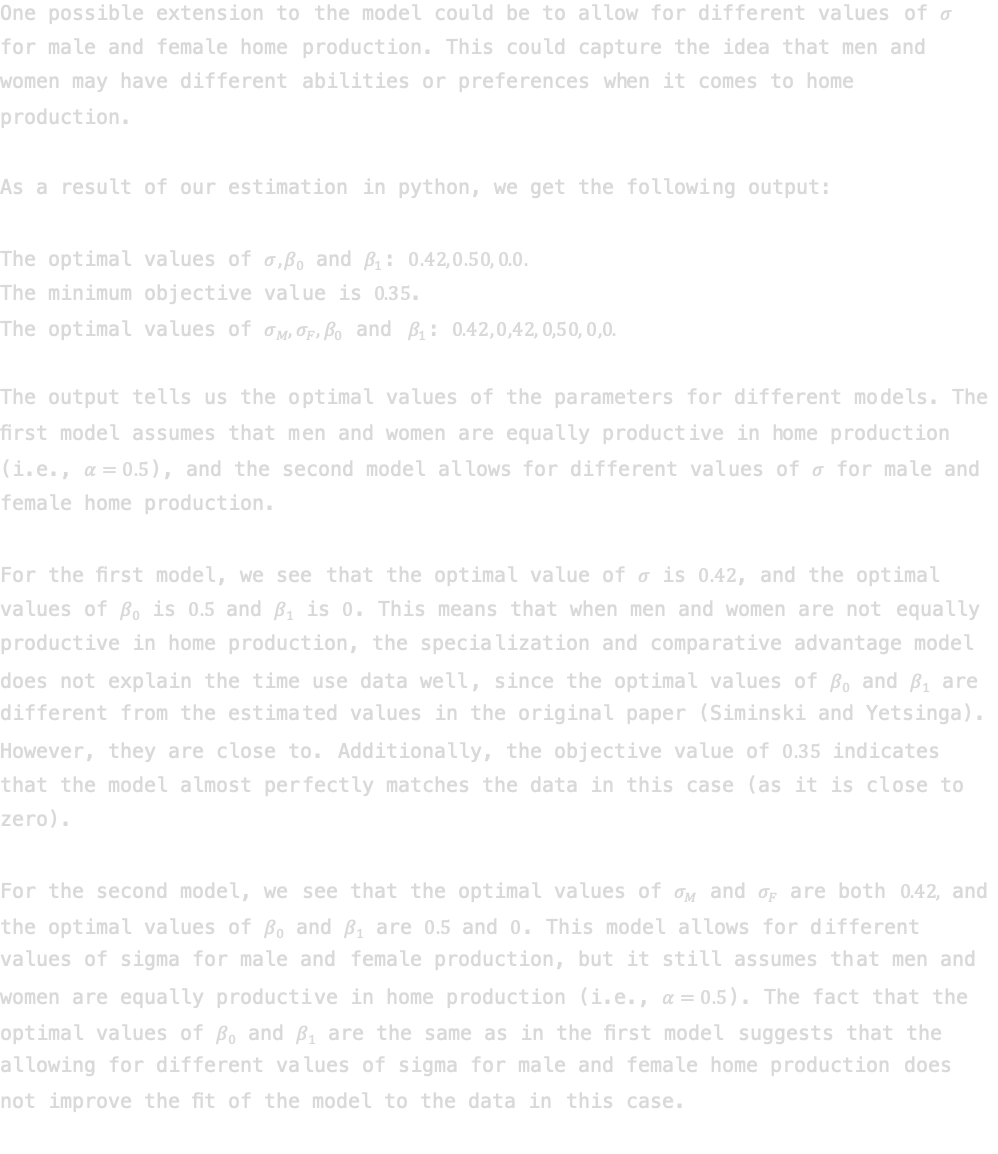